In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%bash
uname -a
whoami

which cmsRun

Linux vinavx3.cern.ch 3.10.0-693.2.2.el7.x86_64 #1 SMP Tue Sep 12 22:26:13 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
/cvmfs/cms.cern.ch/slc7_amd64_gcc630/cms/cmssw/CMSSW_9_4_0/bin/slc7_amd64_gcc630/cmsRun


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool
from DataFormats.FWLite import Handle, Events
from FWLiteUtils import *

Welcome to JupyROOT 6.10/09


In [4]:
def loadTracks(tracks, weight, tkParsA) :
    for tk in tracks.product() :
        if not tk.trackHighPurity() : continue
        if (tk.pt()<0.7) : continue
        # if (abs(tk.dz(pvp))>0.5) : continue # only PV tracks
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(), weight])


In [5]:
def loop(args) :
    tkParsA = []
    ne = 0
    files = args[0]
    l = args[1]
    for f in files :
        print f
        events = Events(f)
        ls = eventsInLumiRange(f, events,l[0],l[1])
        if not ls : continue
        mini = Mini()
        a= events.to(ls[0][0])
        mini.set(events)
        rid = runid(events,mini.ilumi()) 
        zbi = mini.zbIndex(events)
        print "ZB indeces: ", zbi
        names = events.object().triggerNames(mini.triggerBits[0].product())
        for i in xrange(mini.triggerBits[0].product().size()):
            if mini.triggerBits[0].product().accept(i) :print "Trigger ", i, names.triggerName(i)
        for l in ls : 
         for i in range(l[0],l[1]) :
          a= events.to(i)
          mini.set(events)
          ok = False
          for t in zbi : 
            if (mini.triggerBits[0].product().accept(t)) :
                ok = True
                break
          if (i%5000==0) : 
            evid = runid(events,mini.ilumi())
            print "Event", i , evid
          if not ok : continue
          weight = 100./mini.ilumi()
          ne+=1
          loadTracks(mini.cand[0], weight, tkParsA)
          loadTracks(mini.ltk[0], weight, tkParsA)
      
    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA), dtype=np.float)
    print len(tkPars)
    print 'done'
    return (rid,ne,tkPars)

In [6]:
def loadFile(name) :
    loaded = np.load('/tmp/'+name+'.npz')
    runid = loaded['arr_0']
    ne = loaded['arr_1']
    n = len(runid)
    tkPars = [loaded['arr_'+str(i+2)] for i in range(0,n)]
    return runid,ne,tkPars
def saveFile(name,runid,ne,tkPars) :
    np.savez_compressed('/tmp/'+name,runid,ne,*tkPars)

In [14]:
AOD = False
f1 = fullFileName(tier0+'/store/data/Run2017F/ZeroBias4/MINIAOD/PromptReco-v1/000/306/432/00000/', \
['2E885A64-3EC7-E711-8D0D-02163E019C87.root','8E9534C0-40C7-E711-A529-02163E0140D6.root','D09D212D-51C7-E711-A545-02163E014412.root']
                 )
#f2 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/135/00000/8C5C6752-63C5-E711-B4C4-02163E0120F0.root']
#f3 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/138/00000/7E3B50A2-3AC6-E711-A1BF-02163E01A62C.root']
#f4 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/139/00000/EEDAA3C7-2AC6-E711-B2EF-02163E011C96.root']
#l1 = (174,186)
#l2 = (300,330)
#l3 = (0,1000)

f2 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/459/00000/56E15CC8-DDC7-E711-ABBB-02163E014246.root']
f3 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/458/00000/2A4D8F6B-D7C7-E711-A09F-02163E013919.root']
f4 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/454/00000/6EBC0755-77C7-E711-BA27-02163E01473C.root',\
      tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/454/00000/244CEE7E-EEC7-E711-A298-02163E01A274.root'
     ]
f5 = [tier0+'/store/data/Run2017F/ZeroBias/MINIAOD/PromptReco-v1/000/306/462/00000/4433EFC2-A1C8-E711-8FC4-02163E01365D.root']

l1 = (174,186)
l2 = (300,330)
l459 = (1700,2000)
l454 = (21,100)
l462 = (1,85)
lall = (2,2000)

if (AOD) :
    p = Pool(6)
    ret = p.map(loop,[(f1,l1),(f1,l2),(f2,l459),(f3,lall),(f4,l454),(f5,l462)])
    
#ne,tkPars = zip(*ret)

In [15]:
if (AOD) : p.terminate()

In [16]:
if (AOD) : 
   rid,ne,tkPars = zip(*ret)
else :
      rid,ne,tkPars = loadFile('minBiasF2')
print len(rid)
if (AOD) : saveFile('minBiasF2',rid,ne,tkPars)

6


In [17]:
def onePlot(rid,ne,tkPars) :
    eta=0
    phi=1
    pt=2
    w=3
    lmx = 100./np.amin(tkPars[w])
    lmi = 100./np.amax(tkPars[w])
    lab = rid+'  {:d}:{:.2e}->{:.2e}'.format(ne,lmi,lmx)
    ya,x = np.histogram(tkPars[eta],np.linspace(-3.1,3.1,62),weights=10./float(ne)*tkPars[w])
    x.resize(len(ya))
    plt.step(x,ya,where='post',label=lab)
    return ya,x,lab
def plots(rid,ne,tkPars) :
    eta=0
    phi=1
    pt=2
    w=3
    yx = map(onePlot,rid,ne,tkPars)
    yy,xx,lab = zip(*yx)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1,3.1)
    plt.xlabel('eta')
    plt.ylabel('dn/deta')
    plt.show()

    k=0
    for y in yy :
        plt.step(xx[0],y/yy[0],where='post',label=lab[k])
        k+=1
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim(-3.1,3.1)
    plt.xlabel('eta')
    plt.ylabel('eff')
    plt.show()


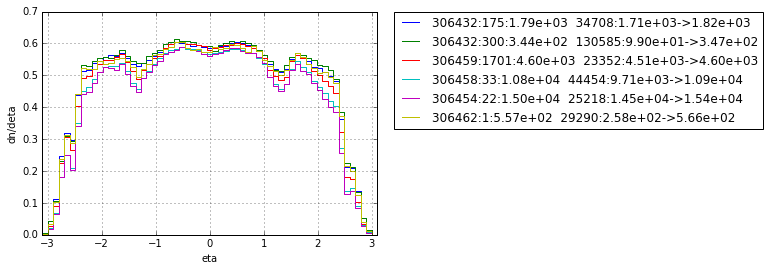

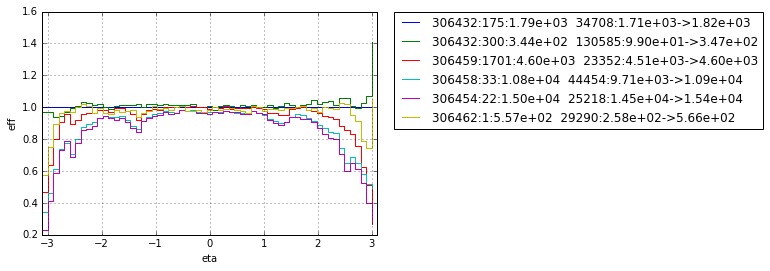

In [18]:
plots(rid,ne,tkPars)

inf


/cvmfs/cms.cern.ch/slc7_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


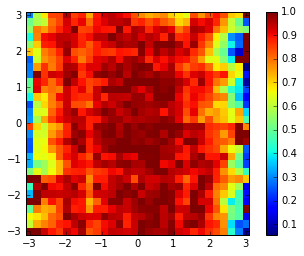

inf


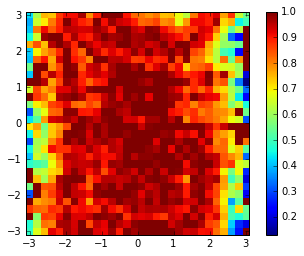

In [19]:
def plot2D(tk1,ne1,tk2,ne2):
    eta=0
    phi=1
    pt=2
    w=3
    nbins = 31
    edges = np.linspace(-3.1,3.1,nbins)
    z1,x,y = np.histogram2d(tk1[eta],tk1[phi],bins=(edges, edges),weights=10./float(ne1)*tk1[w])
    z2,x,y = np.histogram2d(tk2[eta],tk2[phi],bins=(edges, edges),weights=10./float(ne2)*tk2[w])
    z=z2.T/z1.T
    print np.amax(z)
    z = np.fmin(z,1.)
    plt.imshow(z, interpolation='nearest', origin='low', extent=[edges[0], edges[-1], edges[0], edges[-1]])
    plt.colorbar()
    plt.show()

plot2D(tkPars[1],ne[1],tkPars[4],ne[4])
plot2D(tkPars[5],ne[5],tkPars[4],ne[4])